# Plot SSH changes for easterly simulations
The simulations run from '2150-01-01' to '2164-12-31'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import xgcm
import xarray.ufuncs as xu

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:36819' processes=4 threads=4, memory=11.23 GiB>

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last either last 5 years or first year of simulation:
year_flag = 2
if year_flag == 0:
    # Last 5 years
    start_time='2160-01-01'
    end_time='2164-12-31'
elif year_flag == 1:
    # First year
    start_time='2150-01-01'
    end_time='2150-12-31'
elif year_flag == 2:
    # All 15 years
    start_time='2150-01-01'
    end_time='2164-12-31'
    
lat_slice  = slice(-80,-58)
lon_slice  = slice(-280, 80)

### Import data

Bathymetry

In [4]:
# topography data for plotting (on u-grid):
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

ht = ht.sel(yt_ocean=lat_slice)

ft_size=16

Load SSH

In [5]:
# Control
SSH_con = cc.querying.getvar(control, 'sea_level', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
SSH_con = SSH_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))#.mean('time')

# Perturbation up
SSH_up = cc.querying.getvar(easterlies_up, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) 
SSH_up = SSH_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))#.mean('time')

# Perturbation down
SSH_down = cc.querying.getvar(easterlies_down, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
SSH_down = SSH_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))#.mean('time')

Monthly climatology

In [13]:
if year_flag in (0, 1):
    SSH_con  = SSH_con.groupby('time.month').mean('time')
    SSH_up   = SSH_up.groupby('time.month').mean('time')
    SSH_down = SSH_down.groupby('time.month').mean('time')

In [14]:
SSH_con  = SSH_con.load()
SSH_up   = SSH_up.load()
SSH_down = SSH_down.load()

Plotting information

In [6]:
fig_path = '/g/data/x77/wgh581/Figures/Easterlies-Collab/'

In [7]:
import matplotlib.path as mpath
import cartopy.crs as ccrs

In [8]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [9]:
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

In [10]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

In [11]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [12]:
month_long = np.vstack((month,) * 15).reshape(180)

### Circumpolar projection

Annual average

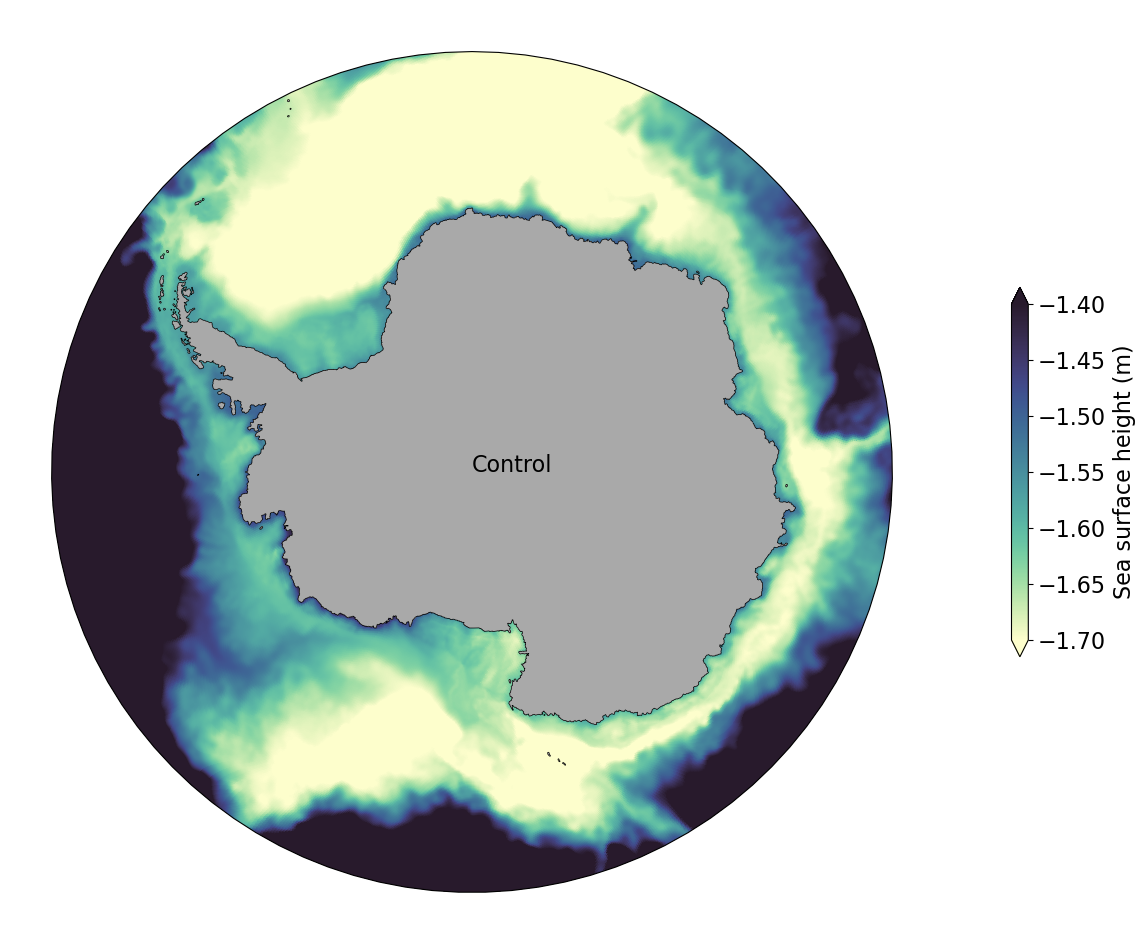

In [18]:
# Control

fig = plt.figure(1, figsize=(20,12))


ax = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)

# Plot land
ax.contourf(SSH_con.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
ax.contour(SSH_con.xt_ocean, SSH_con.yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
# Plot velocity
plt.text(0, 0, 'Control', fontsize=ft_size)
sc = ax.pcolormesh(SSH_con.xt_ocean, SSH_con.yt_ocean, SSH_con.mean('month'), transform = ccrs.PlateCarree(), cmap=cmocean.deep, vmin=-1.7, vmax=-1.4)
cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.5, 0.25, 0.1), aspect=15)
cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

# Finished        
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SSH_map_control.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

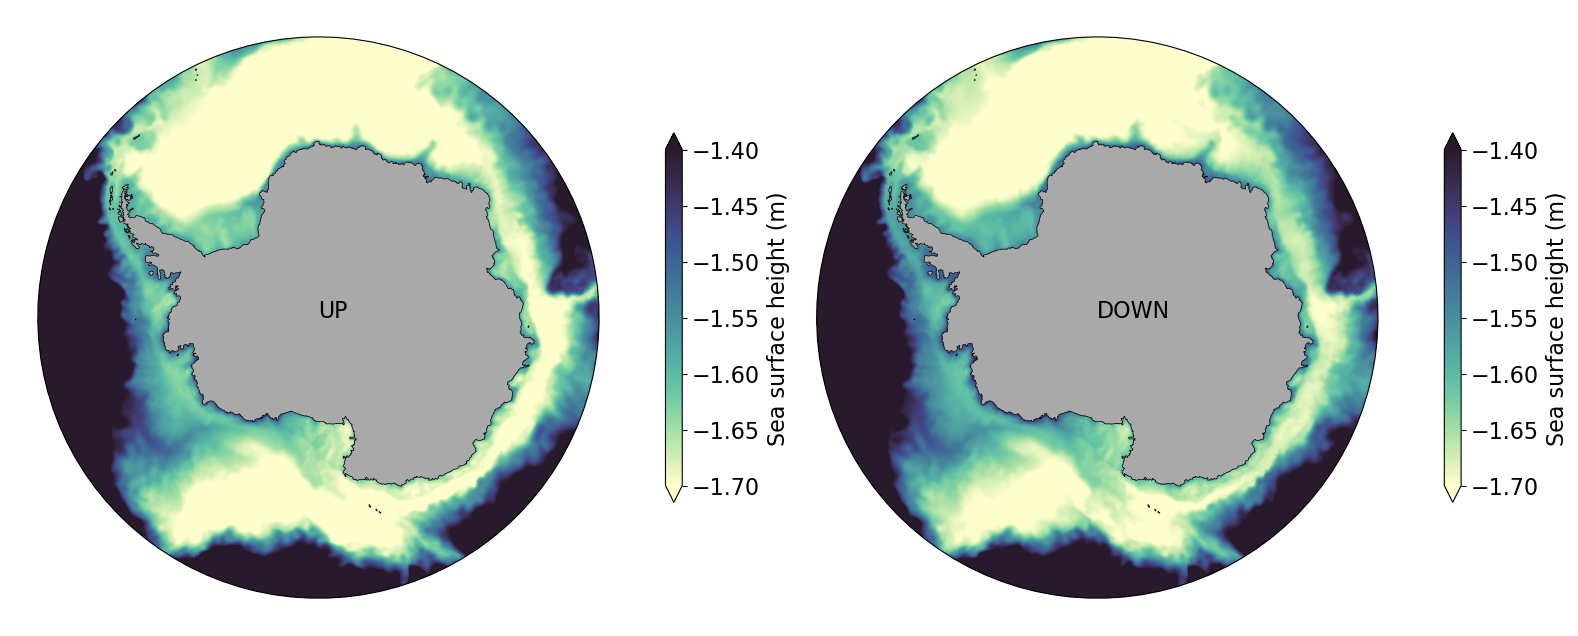

In [56]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'UP', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_up.mean('month'), transform = ccrs.PlateCarree(), cmap=cmocean.deep, vmin=-1.7, vmax=-1.4)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)
        
    if ii == 1:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'DOWN', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_down.mean('month'), transform = ccrs.PlateCarree(), cmap=cmocean.deep, vmin=-1.7, vmax=-1.4)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

Annual average, anomalies

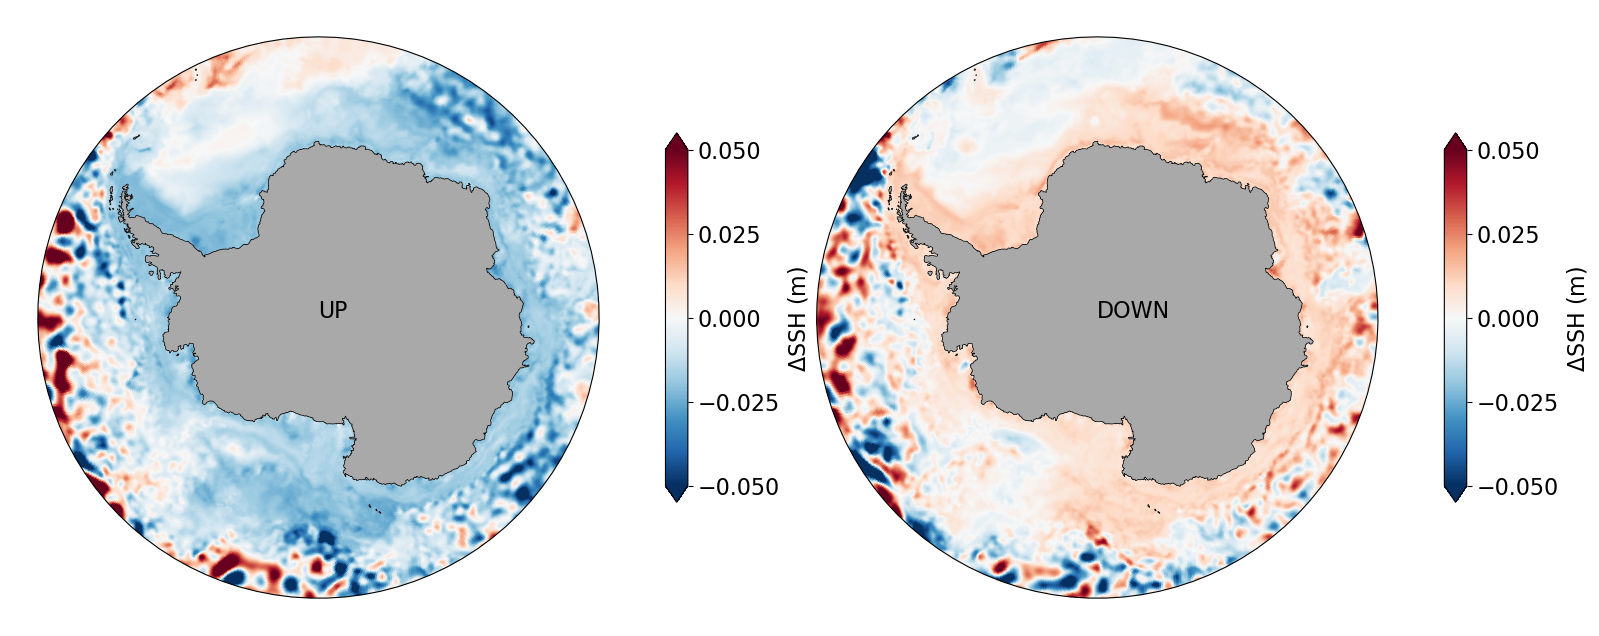

In [19]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'UP', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_up.mean('month')-SSH_con.mean('month'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.05, vmax=0.05)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.1, 0.15, 0.025), aspect=15)
        cbar.set_label('$\Delta$SSH (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)
        
    if ii == 1:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'DOWN', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_down.mean('month')-SSH_con.mean('month'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.05, vmax=0.05)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.1, 0.15, 0.025), aspect=15)
        cbar.set_label('$\Delta$SSH (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

# Finished        
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SSH_map_anomaly_UP_DOWN.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Monthly climatology

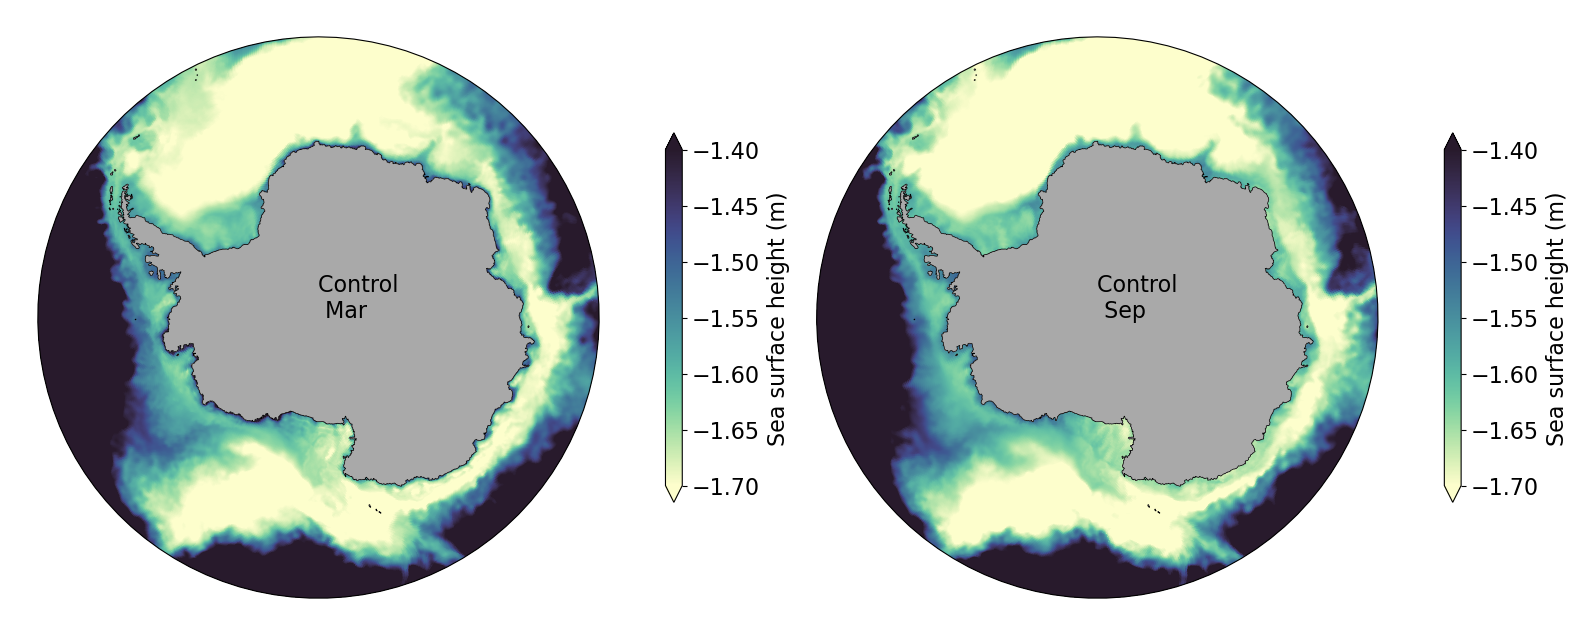

In [24]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'Control \n %s'%month[2], fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_con[2,:,:], transform = ccrs.PlateCarree(), cmap=cmocean.deep, vmin=-1.7, vmax=-1.4)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)
        
    if ii == 1:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'Control \n %s'%month[8], fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_con[8,:,:], transform = ccrs.PlateCarree(), cmap=cmocean.deep, vmin=-1.7, vmax=-1.4)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

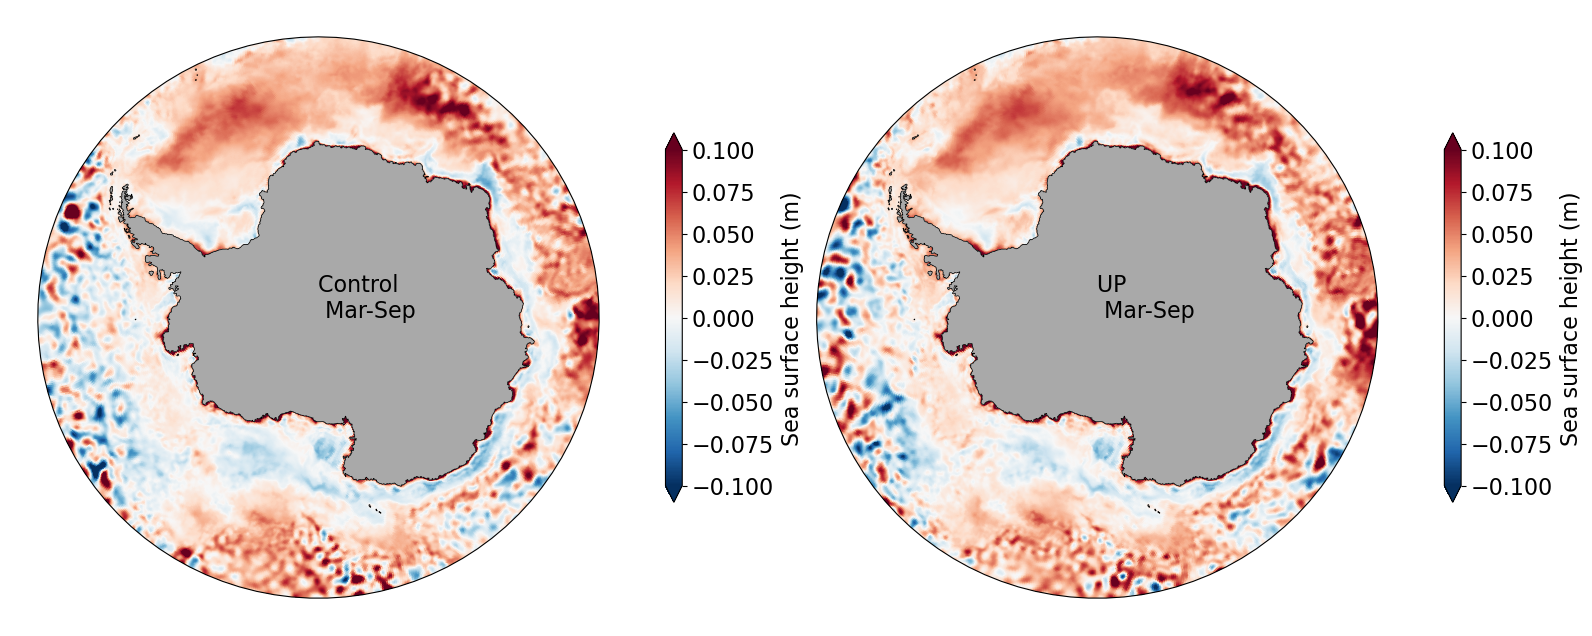

In [12]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'Control \n Mar-Sep', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_con[2,:,:] - SSH_con[8,:,:], transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)
        
    if ii == 1:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'UP \n Mar-Sep', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_up[2,:,:]-SSH_up[8,:,:], transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

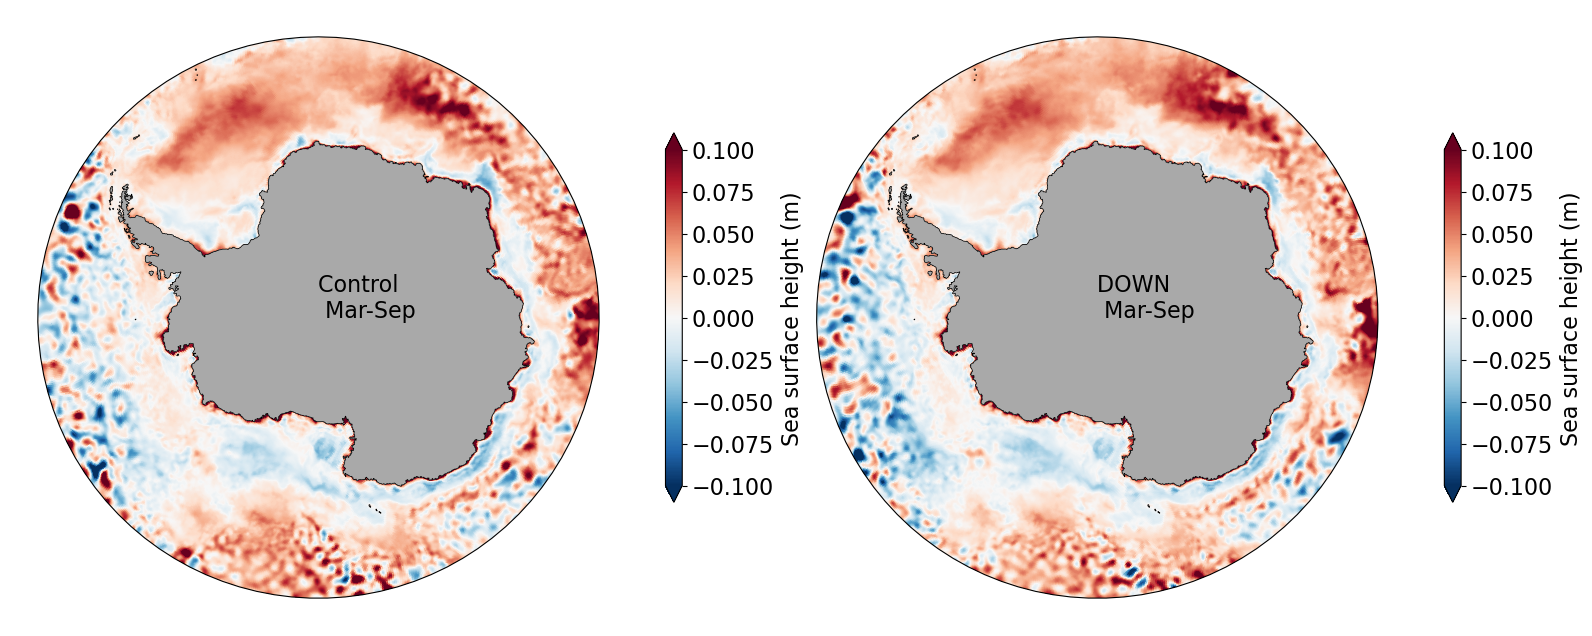

In [13]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'Control \n Mar-Sep', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_con[2,:,:] - SSH_con[8,:,:], transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)
        
    if ii == 1:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'DOWN \n Mar-Sep', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_down[2,:,:]-SSH_down[8,:,:], transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.1, 0.15, 0.05), aspect=15)
        cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

---

Plot slope of SSH along transects (those we looked at to check temp and salt + isopycnals)

In [16]:
transects_names = ['Mertz', 'Prydz', 'PrydzW', 'AmundsenE', 'AmundsenW', 'Totten', 'VincennesBay']
transects_lon   = [-220, 60, 35.5, -107, -135, -242, -253]
transects_lat   = [-67, -64.5, -67.5, -64, -69.5, -66, -75, -70, -74.75, -73, -67.5, -64, -67, -63]
transect_color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

In [22]:
def load_transect(lon_val, lat_min, lat_max):
    
    # Import data
    data_tmp_con  = cc.querying.getvar(control, 'sea_level', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    data_tmp_con  = data_tmp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=slice(lat_min, lat_max)).sel(xt_ocean=lon_val, method='nearest')
    data_tmp_up   = cc.querying.getvar(easterlies_up, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    data_tmp_up   = data_tmp_up.sel(time=slice(start_time,end_time)).sel(yt_ocean=slice(lat_min, lat_max)).sel(xt_ocean=lon_val, method='nearest')
    data_tmp_down = cc.querying.getvar(easterlies_down, 'sea_level', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    data_tmp_down = data_tmp_down.sel(time=slice(start_time,end_time)).sel(yt_ocean=slice(lat_min, lat_max)).sel(xt_ocean=lon_val, method='nearest')
    
    # Monthly climatology
    data_tmp_con  = data_tmp_con.groupby('time.month').mean('time')
    data_tmp_up   = data_tmp_up.groupby('time.month').mean('time')
    data_tmp_down = data_tmp_down.groupby('time.month').mean('time')
    
    # Finished
    data_tmp_con = data_tmp_con.load()
    data_tmp_up = data_tmp_up.load()
    data_tmp_down = data_tmp_down.load()
    return data_tmp_con, data_tmp_up, data_tmp_down

In [18]:
lon_val = -220
lat_min = -67
lat_max = -64.5
data_tmp_down = cc.querying.getvar(easterlies_up, 'sea_level', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time) 
data_tmp_down = data_tmp_down.sel(time=slice(start_time,end_time)).sel(yt_ocean=slice(lat_min, lat_max)).sel(xt_ocean=lon_val, method='nearest')

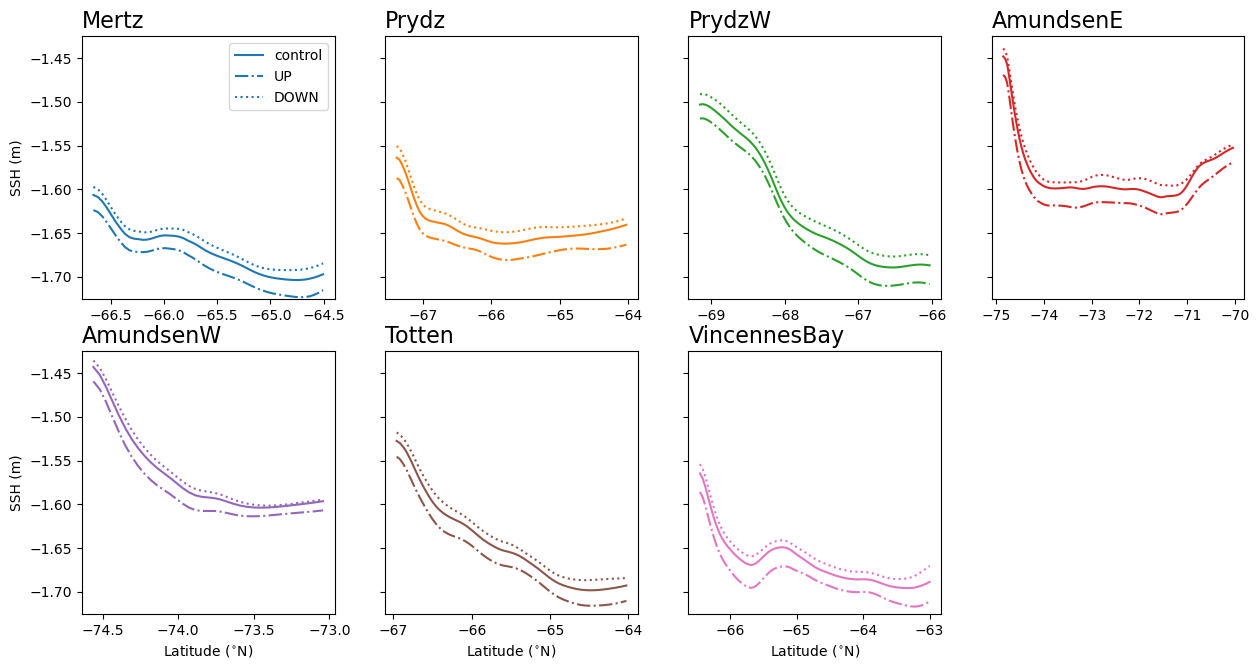

In [45]:
transect_color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

fig = plt.figure(figsize=(15, 7.5))

for ii in range(len(transects_names)):
    plt.subplot(2,4,ii+1)
    plt.title(transects_names[ii], loc='left', fontsize=ft_size)
    transect_con, transect_up, transect_down = load_transect(transects_lon[ii], transects_lat[ii*2], transects_lat[(ii*2)+1])
    plt.plot(transect_con.yt_ocean, transect_con.mean('month'), color=transect_color[ii], label='control')
    plt.plot(transect_up.yt_ocean, transect_up.mean('month'), '-.', color=transect_color[ii], label='UP')
    plt.plot(transect_down.yt_ocean, transect_down.mean('month'), ':', color=transect_color[ii], label='DOWN')
    if ii >= 4:
        plt.xlabel('Latitude ($^{\circ}$N)')
    if ii in (0, 4):
        plt.ylabel('SSH (m)')
    if ii not in (0, 4):
        plt.tick_params(labelleft=False)
    plt.ylim(-1.725, -1.425)
    if ii == 0:
        plt.legend()

# Finished        
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SSH_transects.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

---

First year of perturbation

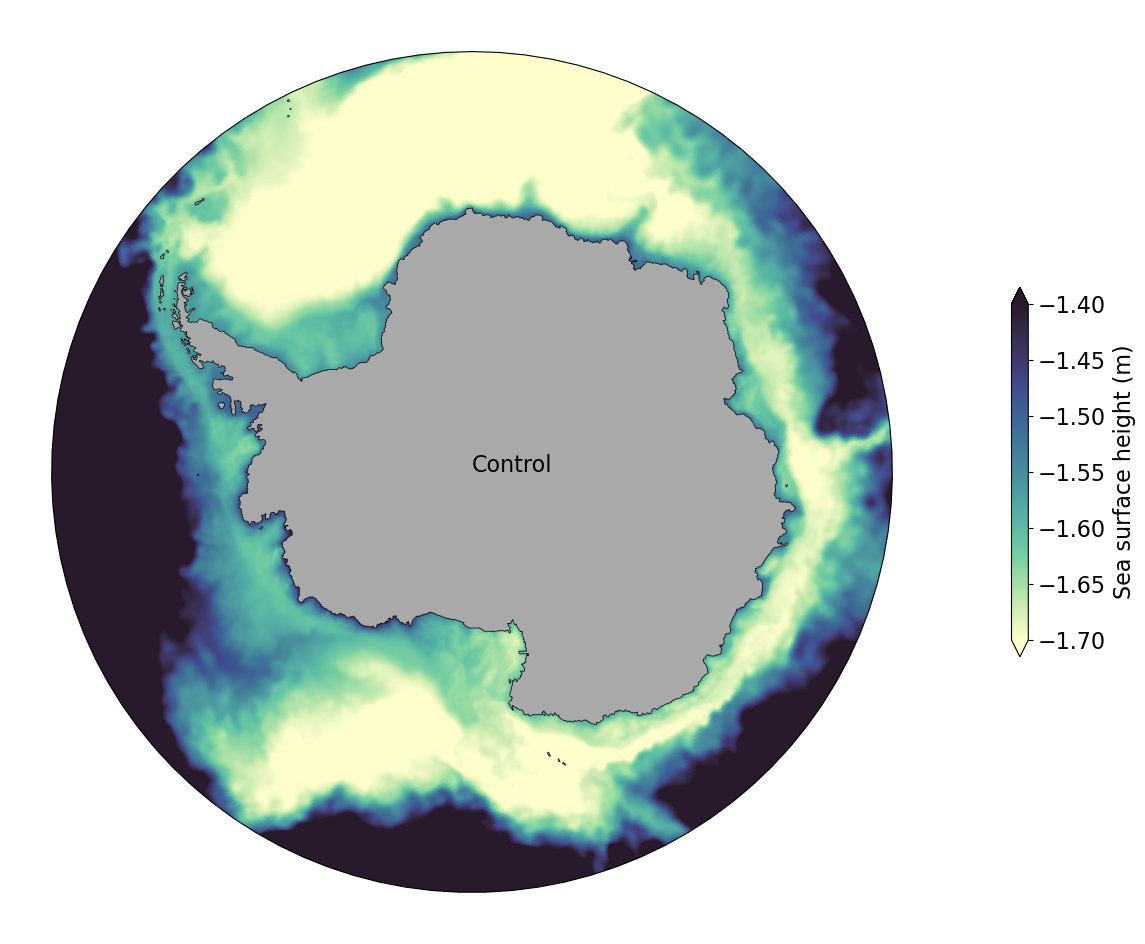

In [11]:
# Control

fig = plt.figure(1, figsize=(20,12))


ax = plt.subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)

# Plot land
ax.contourf(SSH_con.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
ax.contour(SSH_con.xt_ocean, SSH_con.yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
# Plot velocity
plt.text(0, 0, 'Control', fontsize=ft_size)
sc = ax.pcolormesh(SSH_con.xt_ocean, SSH_con.yt_ocean, SSH_con.mean('month'), transform = ccrs.PlateCarree(), cmap=cmocean.deep, vmin=-1.7, vmax=-1.4)
cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both')#, ticks=np.arange(-0.5, 0.25, 0.1), aspect=15)
cbar.set_label('Sea surface height (m)', fontsize=ft_size, labelpad=5)
cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

# Finished        
save_flag = 0
if save_flag == 1:
    fig_name = 'Fig_SSH_map_control_year1.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

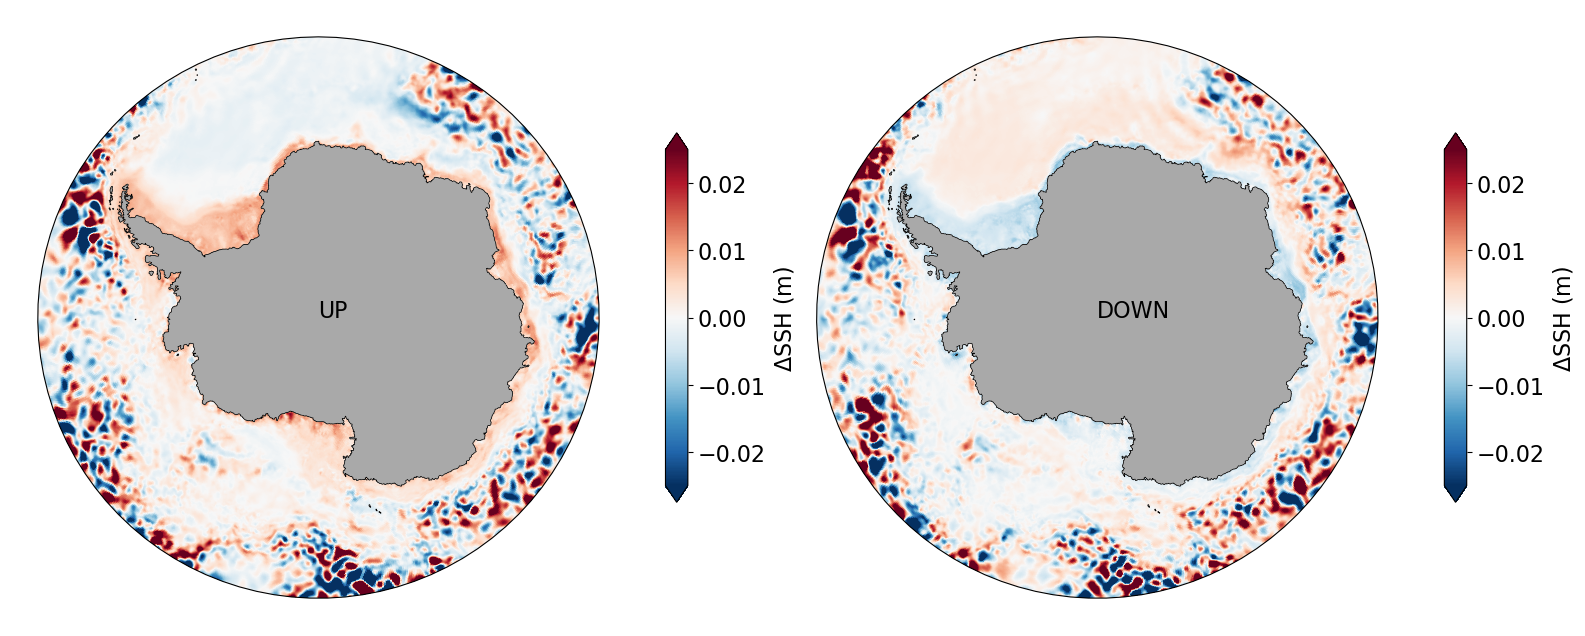

In [15]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'UP', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_up.mean('month')-SSH_con.mean('month'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.025, vmax=0.025)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.1, 0.15, 0.01), aspect=15)
        cbar.set_label('$\Delta$SSH (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)
        
    if ii == 1:
        ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        plt.text(0, 0, 'DOWN', fontsize=ft_size)
        sc = ax.pcolormesh(xt_ocean, yt_ocean, SSH_down.mean('month')-SSH_con.mean('month'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.025, vmax=0.025)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.1, 0.15, 0.01), aspect=15)
        cbar.set_label('$\Delta$SSH (m)', fontsize=ft_size, labelpad=5)
        cbar.ax.tick_params(labelsize=ft_size)

plt.subplots_adjust(wspace=0.01)

# Finished        
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SSH_map_anomaly_UP_DOWN_year1.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

In [ ]:
transect_color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

fig = plt.figure(figsize=(15, 7.5))

for ii in range(len(transects_names)):
    plt.subplot(2,4,ii+1)
    plt.title(transects_names[ii], loc='left', fontsize=ft_size)
    transect_con, transect_up, transect_down = load_transect(transects_lon[ii], transects_lat[ii*2], transects_lat[(ii*2)+1])
    plt.plot(transect_con.yt_ocean, transect_con.mean('month'), color=transect_color[ii], label='control')
    plt.plot(transect_up.yt_ocean, transect_up.mean('month'), '-.', color=transect_color[ii], label='UP')
    plt.plot(transect_down.yt_ocean, transect_down.mean('month'), ':', color=transect_color[ii], label='DOWN')
    if ii >= 4:
        plt.xlabel('Latitude ($^{\circ}$N)')
    if ii in (0, 4):
        plt.ylabel('SSH (m)')
    if ii not in (0, 4):
        plt.tick_params(labelleft=False)
    plt.ylim(-1.725, -1.425)
    if ii == 0:
        plt.legend()

# Finished        
save_flag = 0
if save_flag == 1:
    fig_name = 'Fig_SSH_transects_year1.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

---

## Time series

In [ ]:
# Rerun cell from beginning choosing appropriate flag  to load all 15 years.

Select continental shelf

In [13]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

In [14]:
SSH_con_mask, shelf_mask  = shelf_mask_isobath(SSH_con)
SSH_up_mask, shelf_mask   = shelf_mask_isobath(SSH_up)
SSH_down_mask, shelf_mask = shelf_mask_isobath(SSH_down)

Area weighting

In [15]:
area_t = cc.querying.getvar(control,'area_t', master_session, ncfile='ocean_grid.nc', n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [16]:
# apply to data and area weight:
SSH_con_shelf  = (SSH_con_mask*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
SSH_up_shelf   = (SSH_up_mask*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
SSH_down_shelf = (SSH_down_mask*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum

In [17]:
SSH_con_shelf  = SSH_con_shelf.load()
SSH_up_shelf   = SSH_up_shelf.load()
SSH_down_shelf = SSH_down_shelf.load()

In [21]:
# Annual average
if year_flag == 2:
    SSH_con_shelf_yr  = SSH_con_shelf.groupby('time.year').mean('time')
    SSH_up_shelf_yr   = SSH_up_shelf.groupby('time.year').mean('time')
    SSH_down_shelf_yr = SSH_down_shelf.groupby('time.year').mean('time')

Monthly climatology of control run

In [18]:
# Create array with monthly climatology of control run, to be subtracted from the perturbation runs
# Circumpolar average time series
SSH_con_shelf_CLIMA = SSH_con_shelf.groupby('time.month').mean('time').values
SSH_con_shelf_clima = np.vstack((SSH_con_shelf_CLIMA,) * 15).reshape(180)

In [19]:
# Full field
SSH_con_mask_CLIMA = SSH_con_mask.groupby('time.month').mean('time')
SSH_con_mask_CLIMA = SSH_con_mask_CLIMA.load()

In [21]:
max_min = (SSH_con_shelf_CLIMA[4] - SSH_con_shelf_CLIMA[10]).round(3)

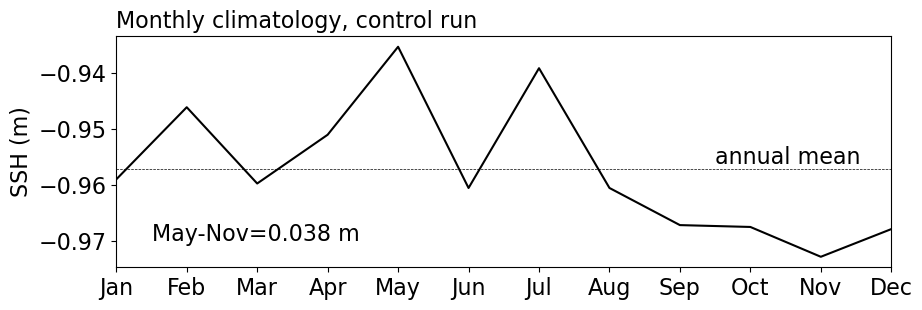

In [32]:
fig = plt.figure(figsize=(10, 3))
plt.plot(SSH_con_shelf_CLIMA, color='k')
plt.axhline(SSH_con_shelf_CLIMA.mean(), linestyle='--', color='k', linewidth=0.5)
plt.text(8.5, SSH_con_shelf_CLIMA.mean()+0.001, 'annual mean')
plt.text(0.5, -0.97, 'May-Nov=%s m'%max_min)
plt.ylabel('SSH (m)', fontsize=ft_size)
plt.xticks(ticks=np.arange(0, 12, 1), labels=month)
plt.xlim(0, 11)
plt.title('Monthly climatology, control run', fontsize=ft_size, loc='left')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SSH_control_monthly_climatology.png'
    plt.savefig(fig_path+fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Full time series

In [22]:
def plot_full_time_series(my_flag):
    fig = plt.figure(figsize=(15, 5))

    if my_flag == 0:
        # Monthly values
        plt.plot(SSH_con_shelf.time.values, SSH_con_shelf, color='k', label='control')
        plt.plot(SSH_up_shelf.time.values, SSH_up_shelf, color='C0', label='UP')
        plt.plot(SSH_down_shelf.time.values, SSH_down_shelf, color='C1', label='DOWN')
    elif my_flag == 1:
        # Annual average
        plt.plot(SSH_con_shelf_yr.year, SSH_con_shelf_yr, color='k', label='control')
        plt.plot(SSH_up_shelf_yr.year, SSH_up_shelf_yr, color='C0', label='UP')
        plt.plot(SSH_down_shelf_yr.year, SSH_down_shelf_yr, color='C1', label='DOWN')
        plt.ylim(-0.97, -0.94)
        plt.xlim(SSH_con_shelf_yr.year.min(), SSH_con_shelf_yr.year.max())
    plt.xlabel('Year')
    plt.ylabel('SSH (m)')
    plt.title('Circumpolar mean, shelf', loc='left')
    plt.legend(ncol=3);

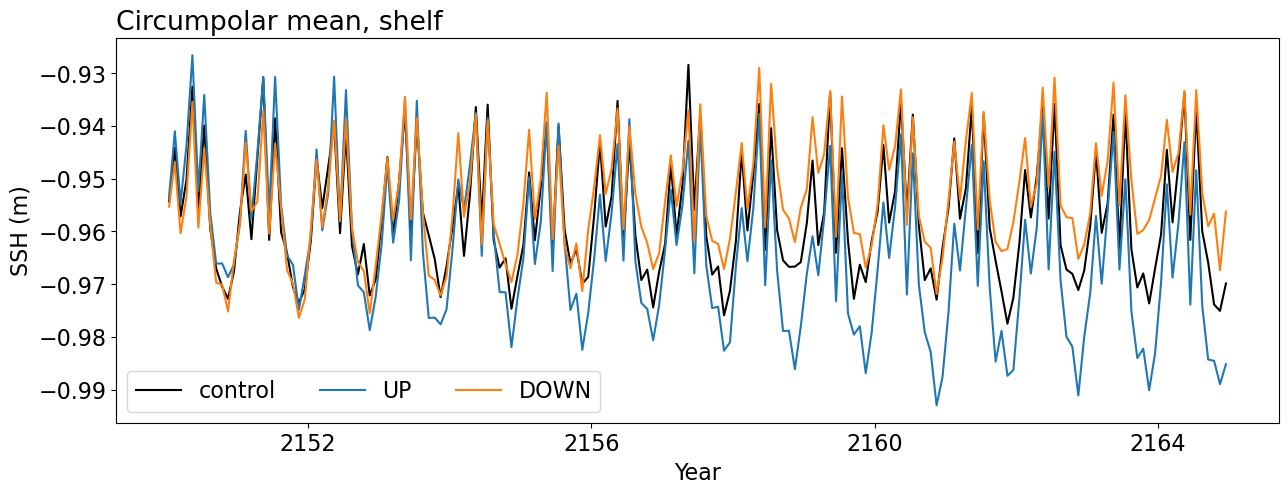

In [23]:
plot_full_time_series(0)

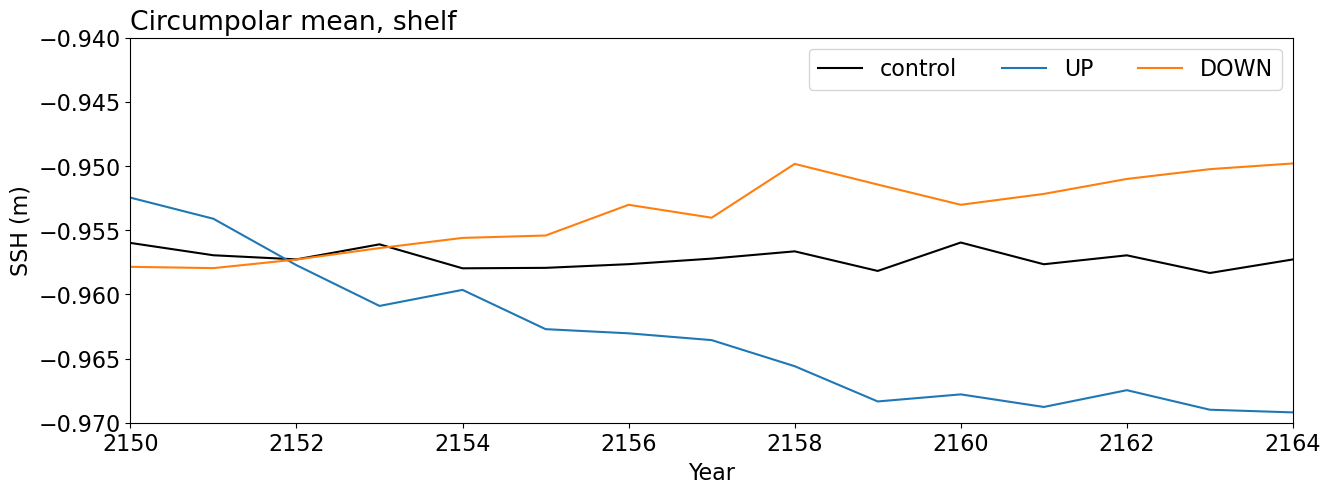

In [24]:
plot_full_time_series(1)

In [22]:
diff_con = (SSH_con_shelf_yr.max()-SSH_con_shelf_yr.min()).values
std_con  = SSH_con_shelf_yr.std().values
print('Control varies (annual average) by: ', diff_con*100, 'cm')
print('Control std (annual average): ', std_con*100, 'cm')

Control varies (annual average) by:  0.23734569549560547 cm
Control std (annual average):  0.07488795672543347 cm


Anomaly time series

In [48]:
def plot_anomaly_time_series(my_flag, save_flag=0):
    fig = plt.figure(figsize=(10, 3))

    if my_flag == 0:
        # Monthly values
        plt.plot(SSH_up_shelf.time, SSH_up_shelf - SSH_con_shelf.mean(), color='C0', label='UP')
        plt.plot(SSH_down_shelf.time, SSH_down_shelf - SSH_con_shelf.mean(), color='C1', label='DOWN')
    if my_flag == 1:
        # Annual average
        plt.plot(SSH_con_shelf_yr.year, SSH_up_shelf_yr - SSH_con_shelf_yr.mean(), color='C0', label='UP')
        plt.plot(SSH_con_shelf_yr.year, SSH_down_shelf_yr - SSH_con_shelf_yr.mean(), color='C1', label='DOWN')
        plt.ylim(-0.015, 0.015)
        plt.xlim(SSH_con_shelf_yr.year.min(), SSH_con_shelf_yr.year.max())
        #plt.fill_between(SSH_con_shelf_yr.year, -diff_con, diff_con, color='0.5', alpha=0.5)
        plt.fill_between(SSH_con_shelf_yr.year, -std_con, std_con, color='0.5', alpha=0.5)
    plt.axhline(0, color='k', linewidth=0.5)
    plt.xlabel('Year')
    plt.ylabel('SSH anomaly (m)')
    plt.title('Circumpolar mean, continental shelf', loc='left')
    plt.legend(ncol=2)

    # Finished        
    if save_flag == 1:
        fig_name = 'Fig_SSH_timeseries_anomaly.png'
        plt.savefig(fig_path+fig_name, dpi=150, bbox_inches='tight', facecolor='white')

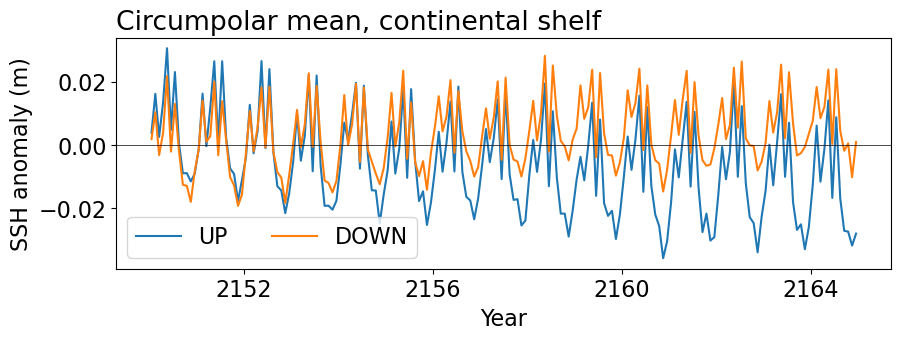

In [55]:
plot_anomaly_time_series(0, 1)

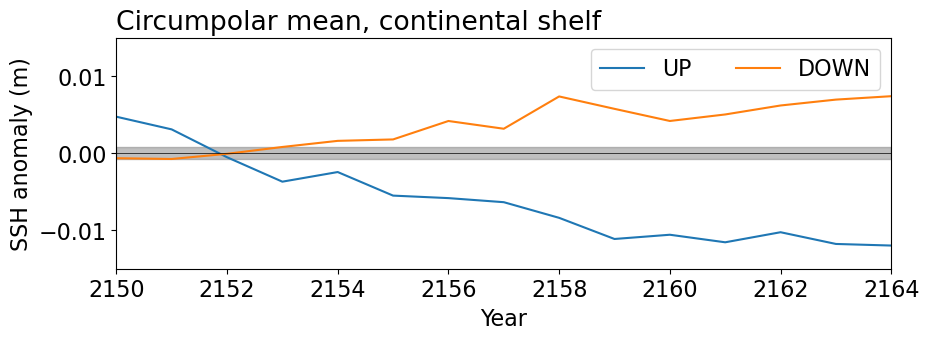

In [54]:
plot_anomaly_time_series(1, 0)

In [45]:
def plot_anomaly_clima_time_series(my_flag, save_flag=0):
    fig = plt.figure(figsize=(10, 3))

    if my_flag == 0:
        # Monthly values
        plt.plot(SSH_up_shelf.time, SSH_up_shelf - SSH_con_shelf_clima, color='C0', label='UP')
        plt.plot(SSH_down_shelf.time, SSH_down_shelf - SSH_con_shelf_clima, color='C1', label='DOWN')
        plt.ylim(-0.02, 0.02)
        plt.yticks(np.arange(-0.02, 0.025, 0.01))
    if my_flag == 1:
        # Annual average
        plt.plot(SSH_con_shelf_yr.year, SSH_up_shelf_yr - SSH_con_shelf_yr.mean(), color='C0', label='UP')
        plt.plot(SSH_con_shelf_yr.year, SSH_down_shelf_yr - SSH_con_shelf_yr.mean(), color='C1', label='DOWN')
        plt.ylim(-0.015, 0.015)
        plt.xlim(SSH_con_shelf_yr.year.min(), SSH_con_shelf_yr.year.max())
        #plt.fill_between(SSH_con_shelf_yr.year, -diff_con, diff_con, color='0.5', alpha=0.5)
        plt.fill_between(SSH_con_shelf_yr.year, -std_con, std_con, color='0.5', alpha=0.5)
    plt.axhline(0, color='k', linewidth=0.5)
    plt.xlabel('Year')
    plt.ylabel('SSH anomaly (m)')
    plt.title('Circumpolar mean, continental shelf', loc='left')
    plt.legend(ncol=2)

    # Finished        
    if save_flag == 1:
        fig_name = 'Fig_SSH_timeseries_anomaly_clima.png'
        plt.savefig(fig_path+fig_name, dpi=150, bbox_inches='tight', facecolor='white')

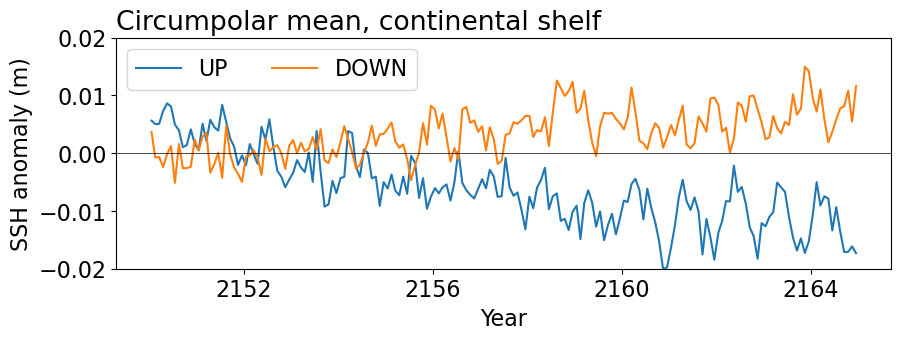

In [47]:
plot_anomaly_clima_time_series(0, 1)

### Animation of the SSH (Annual averages)

In [23]:
import matplotlib.gridspec as gridspec

In [71]:
# Annual average
if year_flag == 2:
    SSH_con_mask_yr  = SSH_con_mask.groupby('time.year').mean('time')
    SSH_up_mask_yr   = SSH_up_mask.groupby('time.year').mean('time')
    SSH_down_mask_yr = SSH_down_mask.groupby('time.year').mean('time')

In [24]:
SSH_con_mask  = SSH_con_mask.load()
SSH_up_mask   = SSH_up_mask.load()
SSH_down_mask = SSH_down_mask.load()

In [76]:
# from xmovie import Movie
# mov = Movie(SSH_up_mask-SSH_con_mask)
# #mov.save('movie.mp4')
# mov.preview(0)

Annual averages

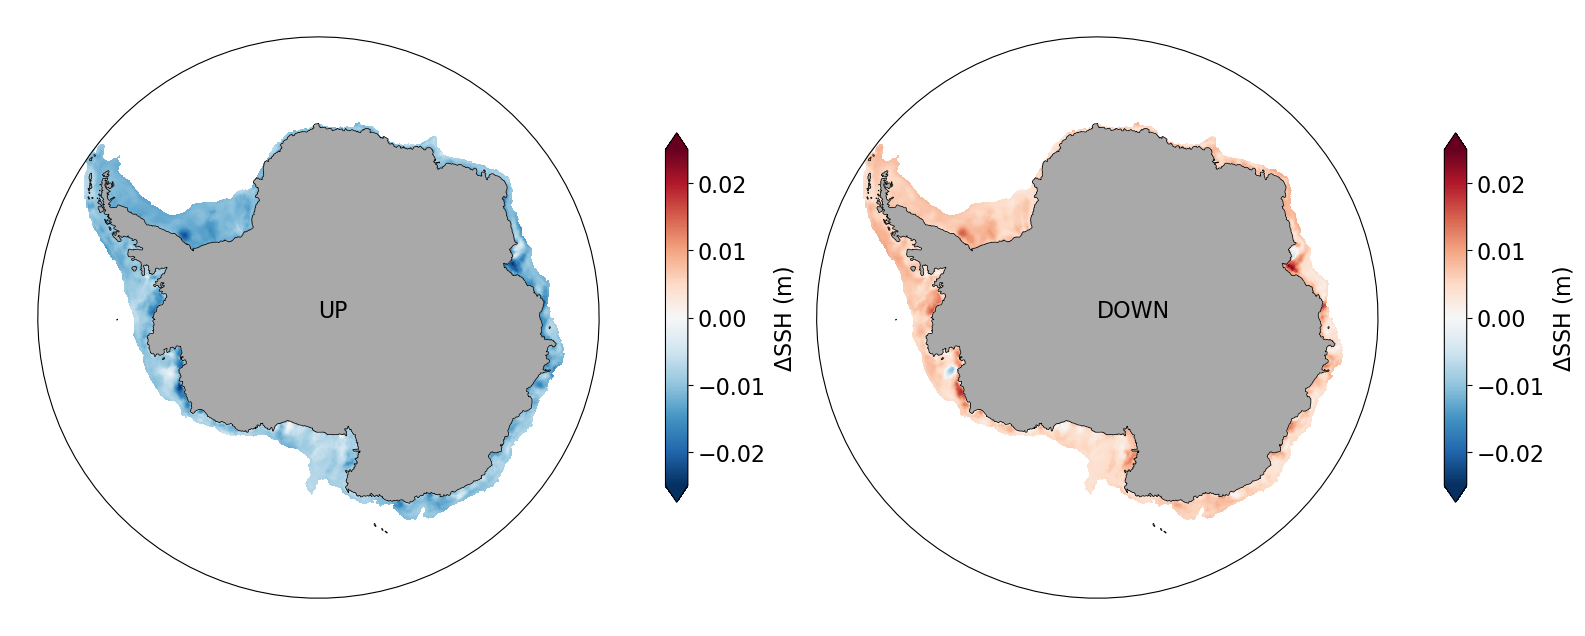

In [80]:
fig = plt.figure(1, figsize=(20,12))

text_name = ['UP', 'DOWN']

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
    ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
    plt.text(0, 0, text_name[ii], fontsize=ft_size)
    if ii == 0:
        sc = ax.pcolormesh(SSH_up_mask_yr.xt_ocean, SSH_up_mask_yr.yt_ocean, SSH_up_mask_yr-SSH_con_mask_yr.mean('year'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.025, vmax=0.025)
    if ii == 1:
        sc = ax.pcolormesh(SSH_up_mask_yr.xt_ocean, SSH_up_mask_yr.yt_ocean, SSH_down_mask_yr-SSH_con_mask_yr.mean('year'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.025, vmax=0.025)
    cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.1, 0.15, 0.01), aspect=15)
    cbar.set_label('$\Delta$SSH (m)', fontsize=ft_size, labelpad=5)
    cbar.ax.tick_params(labelsize=ft_size)  
plt.subplots_adjust(wspace=0.01)

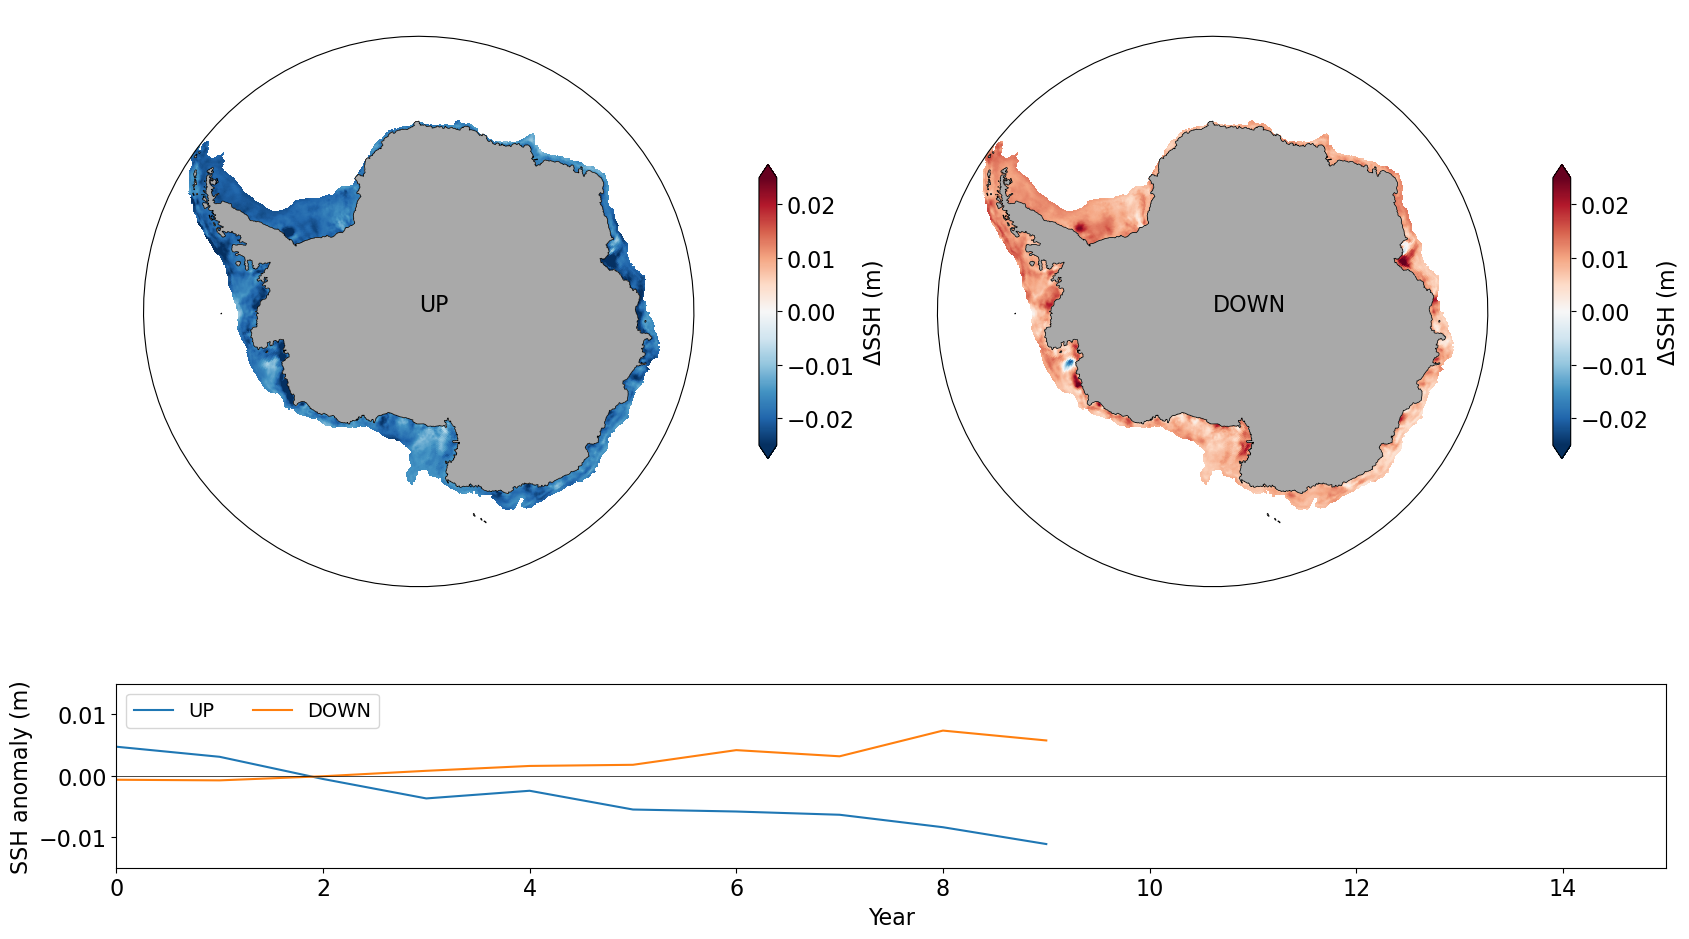

In [192]:

for tt in range(15):
    
    if tt == 9:
        fig = plt.figure(1, figsize=(20,12))
        text_name = ['UP', 'DOWN']

        gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.25], width_ratios=[1, 1], hspace=0.01, wspace=0.05)

        for ii in range(2):

            ax = fig.add_subplot(gs[ii], projection=ccrs.SouthPolarStereo())
            #ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
            ax.set_boundary(circle, transform=ax.transAxes)
            sc = ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
            ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
            plt.text(0, 0, text_name[ii], fontsize=ft_size)
            if ii == 0:
                sc = ax.pcolormesh(SSH_con_mask.xt_ocean, SSH_con_mask.yt_ocean, SSH_up_mask_yr.isel({"year":tt})-SSH_con_mask_yr.mean('year'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.025, vmax=0.025)
            if ii == 1:
                sc = ax.pcolormesh(SSH_con_mask.xt_ocean, SSH_con_mask.yt_ocean, SSH_down_mask_yr.isel({"year":tt})-SSH_con_mask_yr.mean('year'), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.025, vmax=0.025)
            cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.1, 0.15, 0.01), aspect=15)
            cbar.set_label('$\Delta$SSH (m)', fontsize=ft_size, labelpad=5)
            cbar.ax.tick_params(labelsize=ft_size)  
        plt.subplots_adjust(wspace=0.01)

        ax = fig.add_subplot(gs[2:])
        plt.plot((SSH_up_shelf_yr - SSH_con_shelf_yr.mean()).isel(year=slice(0,tt+1)), color='C0', label='UP')
        plt.plot((SSH_down_shelf_yr - SSH_con_shelf_yr.mean()).isel(year=slice(0,tt+1)), color='C1', label='DOWN')
        plt.ylim(-0.015, 0.015)
        #plt.xlim(SSH_con_shelf_yr.year.min(), SSH_con_shelf_yr.year.max())
        plt.xlim(0, 15)
        plt.axhline(0, color='k', linewidth=0.5)
        plt.xlabel('Year', fontsize=ft_size)
        plt.ylabel('SSH anomaly (m)', fontsize=ft_size)
        plt.legend(ncol=2, loc=2)

        # Finished        
        save_flag = 1
        if save_flag == 1:
            if tt < 10:
                yy = '0' + np.str(tt)
            elif tt >= 10:
                yy = np.str(tt)
            fig_name = 'Fig_SSH_anomaly_animation_%s.png'%yy
            plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Monthly values (subtract monthly climatology from control run)

In [25]:
SSH_up_mask_clima = SSH_up_mask.copy()
for ii in range(12):
    SSH_up_mask_clima[ii::12,:,:] = SSH_up_mask[ii::12,:,:] - SSH_con_mask_CLIMA[ii,:,:]

In [26]:
SSH_down_mask_clima = SSH_down_mask.copy()
for ii in range(12):
    SSH_down_mask_clima[ii::12,:,:] = SSH_down_mask[ii::12,:,:] - SSH_con_mask_CLIMA[ii,:,:]

In [27]:
year_long = [np.repeat(1, 12)]
year_long

for ii in range(15):
    if ii == 0:
        year_long = np.repeat(ii+1, 12)
    else:
        year_long = np.append(year_long, np.repeat(ii+1, 12))

In [ ]:
for tt in range(15*12):
    
    if tt > 12*12:
        plt.close()
        fig = plt.figure(1, figsize=(20,12))
        text_name = ['UP', 'DOWN']

        gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.25], width_ratios=[1, 1], hspace=0.01, wspace=0.05)

        for ii in range(2):

            ax = fig.add_subplot(gs[ii], projection=ccrs.SouthPolarStereo())
            #ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
            ax.set_boundary(circle, transform=ax.transAxes)
            sc = ax.contourf(xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
            ax.contour(xt_ocean, yt_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
            plt.text(0, 0, text_name[ii], fontsize=ft_size)
            if ii == 0:
                sc = ax.pcolormesh(SSH_con_mask.xt_ocean, SSH_con_mask.yt_ocean, SSH_up_mask_clima.isel({"time":tt}), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.03, vmax=0.03)
            if ii == 1:
                sc = ax.pcolormesh(SSH_con_mask.xt_ocean, SSH_con_mask.yt_ocean, SSH_down_mask_clima.isel({"time":tt}), transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.03, vmax=0.03)
            cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.1, 0.15, 0.01), aspect=15)
            cbar.set_label('$\Delta$SSH (m)', fontsize=ft_size, labelpad=5)
            cbar.ax.tick_params(labelsize=ft_size)  
        plt.subplots_adjust(wspace=0.01)

        ax = fig.add_subplot(gs[2:])
        plt.plot((SSH_up_shelf - SSH_con_shelf_clima).isel(time=slice(0,tt+1)), color='C0', label='UP')
        plt.plot((SSH_down_shelf - SSH_con_shelf_clima).isel(time=slice(0,tt+1)), color='C1', label='DOWN')
        plt.ylim(-0.02, 0.02)
        plt.title('Year: %s, Month: %s'%(year_long[tt], month_long[tt]), fontsize=ft_size, loc='left')
        plt.xlim(0, 15*12)
        plt.xticks(ticks=np.arange(0, 15*12, 12), labels=np.arange(0, 15, 1))
        plt.axhline(0, color='k', linewidth=0.5)
        plt.xlabel('Year', fontsize=ft_size)
        plt.ylabel('$\Delta$SSH (m)', fontsize=ft_size)
        plt.legend(ncol=2, loc=3)

        # Finished        
        save_flag = 1
        if save_flag == 1:
            if tt < 10:
                yy = '00' + np.str(tt)
            elif tt >= 10 and tt < 100:
                yy = '0' + np.str(tt)
            elif tt >= 100:
                yy = np.str(tt)
            fig_name = 'Fig_SSH_anomaly_animation_clima_%s.png'%yy
            plt.savefig(fig_path + 'animations/' + fig_name, dpi=150, bbox_inches='tight', facecolor='white')